**Mengumpulkan ulasan (reviews)**

In [23]:
pip install requests beautifulsoup4


In [24]:
import requests
from bs4 import BeautifulSoup

def collect_reviews(url, output_file):
    try:
        # Mengirim permintaan ke URL
        response = requests.get(url)
        response.raise_for_status()  # Pastikan tidak ada error HTTP

        # Parsing konten HTML
        soup = BeautifulSoup(response.content, 'html.parser')

        # Mengumpulkan teks ulasan
        reviews = []
        for paragraph in soup.find_all('p'):  # Biasanya ulasan ada di tag <p>
            text = paragraph.get_text().strip()
            if text:  # Hanya tambahkan jika teks tidak kosong
                reviews.append(text)

        # Menyimpan ulasan ke file .txt
        with open(output_file, 'w', encoding='utf-8') as file:
            for review in reviews:
                file.write(review + '\n')

        print(f"Ulasan berhasil disimpan di {output_file}")
    except Exception as e:
        print(f"Terjadi kesalahan: {e}")

# URL contoh dari Gadgetren
url = "https://gadgetren.com/2024/10/21/axioo-hype-5-amd-x3-lollipop-edition-resmi-dijual-292025/"  # Ganti dengan URL yang diinginkan
output_file = "Axioo HYPE 5 AMD X3 Lollipop Edition.txt"
collect_reviews(url, output_file)


Ulasan berhasil disimpan di Axioo HYPE 5 AMD X3 Lollipop Edition.txt


**Processing Teks**

In [25]:
!pip install Sastrawi


In [26]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import pandas as pd
import os
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Pastikan stopwords terunduh
nltk.download('stopwords')

# Daftar stopwords untuk bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

# Inisialisasi stopwords dan stemmer untuk preprocessing
nltk_stopwords = stopwords.words('indonesian')
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi preprocessing untuk teks
def preprocess_text(text):
    # Lexing (menghapus angka)
    text = re.sub(r"\d+", "", text)

    # Lexing (menghilangkan tanda baca)
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Lexing (menghilangkan karakter selain huruf dan spasi)
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Lexing (case folding / mengubah huruf besar menjadi kecil)
    text = text.lower()

    # Lexing (Cleaning / menghapus tautan/url)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Lexing (memisahkan kata per kata)
    words = text.split()

    # Lexing (menghilangkan kata duplikat)
    words = list(dict.fromkeys(words))

    # Filtering (menghapus kata-kata yang tidak penting)
    words = [word for word in words if word not in nltk_stopwords]

    # Stemming (mengubah bentuk kata menjadi kata dasar)
    words = [stemmer.stem(word) for word in words]

    return " ".join(words)


# Daftar nama file untuk diproses
input_files = [
    "Axioo HYPE 5 AMD X3 Lollipop Edition.txt",
    "ASUS Zenbook S 14 OLED (UX5406).txt",
    "Acer Swift 14 AI (SF14-51).txt",
    "MEGABOOK K16S.txt",
    "Review Acer Aspire Vero 16 AI (AV14-51P).txt",
    "TECNO MEGABOOK T1.txt",
    "ASUS ExpertBook P1 (P1403).txt"
]

# Menyimpan hasil ekstraksi untuk semua file
data = []

# Membaca teks dari file dan melakukan preprocessing
df = pd.DataFrame(columns=["File", "Teks Preprocessing"])

for input_file in input_files:
    if os.path.exists(input_file):  # Memastikan file ada
        with open(input_file, "r", encoding="utf-8") as file:
            text = file.read()

        # Langkah 1: Preprocessing teks
        processed_text = preprocess_text(text)

        # Menyimpan hasil preprocessing ke dalam DataFrame
        new_row = pd.DataFrame({'File': [input_file], 'Teks Preprocessing': [processed_text]})
        df = pd.concat([df, new_row], ignore_index=True)

    else:
        print(f"File {input_file} tidak ditemukan.\n")

# Menampilkan teks yang sudah diproses
print("Teks yang sudah diproses:\n")
print(df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Teks yang sudah diproses:

                                           File  \
0      Axioo HYPE 5 AMD X3 Lollipop Edition.txt   
1           ASUS Zenbook S 14 OLED (UX5406).txt   
2                Acer Swift 14 AI (SF14-51).txt   
3                             MEGABOOK K16S.txt   
4  Review Acer Aspire Vero 16 AI (AV14-51P).txt   
5                         TECNO MEGABOOK T1.txt   
6                ASUS ExpertBook P1 (P1403).txt   

                                  Teks Preprocessing  
0  gadgetren rilis laptop gaming seri pongo monit...  
1  gadgetren asus boyong laptop premium baru nama...  
2  gadgetren acer resmi boyong laptop pc copilot ...  
3  gadgetren tecno resmi boyong laptop seri k per...  
4  gadgetren acer hadir laptop ecofriendly pasar ...  
5  gadgetren tecno indonesia kabar segar model la...  
6  summary asus expertbook p laptop bisnis simpel...  


**Ektraksi Fitur + Sentimen Analisis**

In [28]:
!python -m spacy download xx_ent_wiki_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 26.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_ent_wiki_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [29]:
from textblob import TextBlob

# Menambahkan kolom analisis sentimen ke dalam DataFrame yang sudah ada
feature_data_with_sentiment = []

# Ekstraksi fitur dan analisis sentimen untuk setiap teks yang sudah diproses
for index, row in df.iterrows():
    processed_text = row["Teks Preprocessing"]

    # Ekstraksi fitur TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform([processed_text])
    terms = vectorizer.get_feature_names_out()
    scores = X.toarray().flatten()
    term_scores = dict(zip(terms, scores))
    sorted_terms = sorted(term_scores.items(), key=lambda item: item[1], reverse=True)

    # Analisis sentimen menggunakan TextBlob
    blob = TextBlob(processed_text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    if polarity > 0:
        sentiment = 'Positif'
    elif polarity < 0:
        sentiment = 'Negatif'
    else:
        sentiment = 'Netral'

    # Menyimpan hasil TF-IDF dan analisis sentimen
    for term, score in sorted_terms[:20]:
        feature_data_with_sentiment.append({
            'File': row['File'],
            'Jenis': 'Fitur TF-IDF',
            'Entitas/Fitur': term,
            'Skor': score,
            'Sentimen': sentiment,
            'Polaritas': polarity,
            'Subjektivitas': subjectivity
        })

# Membuat DataFrame dari hasil ekstraksi fitur TF-IDF dan analisis sentimen
feature_with_sentiment_df = pd.DataFrame(feature_data_with_sentiment)

# Menampilkan hasil dalam bentuk tabel
print("\nHasil Ekstraksi Fitur TF-IDF dan Analisis Sentimen:")
print(feature_with_sentiment_df.to_string(index=False))



Hasil Ekstraksi Fitur TF-IDF dan Analisis Sentimen:
                                        File        Jenis Entitas/Fitur     Skor Sentimen  Polaritas  Subjektivitas
    Axioo HYPE 5 AMD X3 Lollipop Edition.txt Fitur TF-IDF          beli 0.202260  Negatif  -0.050000       0.253571
    Axioo HYPE 5 AMD X3 Lollipop Edition.txt Fitur TF-IDF        dukung 0.134840  Negatif  -0.050000       0.253571
    Axioo HYPE 5 AMD X3 Lollipop Edition.txt Fitur TF-IDF          guna 0.134840  Negatif  -0.050000       0.253571
    Axioo HYPE 5 AMD X3 Lollipop Edition.txt Fitur TF-IDF         hadir 0.134840  Negatif  -0.050000       0.253571
    Axioo HYPE 5 AMD X3 Lollipop Edition.txt Fitur TF-IDF         layar 0.134840  Negatif  -0.050000       0.253571
    Axioo HYPE 5 AMD X3 Lollipop Edition.txt Fitur TF-IDF         mudah 0.134840  Negatif  -0.050000       0.253571
    Axioo HYPE 5 AMD X3 Lollipop Edition.txt Fitur TF-IDF          nama 0.134840  Negatif  -0.050000       0.253571
    Axioo HYPE 5 AM

**Visualisasi dan Interpretasi Hasil**

<Figure size 1000x600 with 0 Axes>

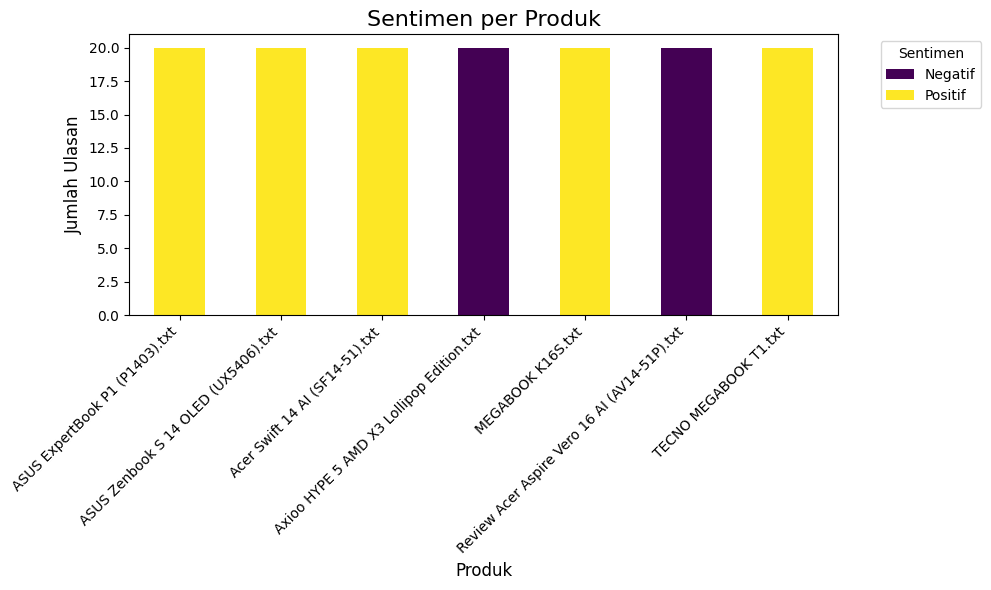

<ipython-input-30-0310cef56490>:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

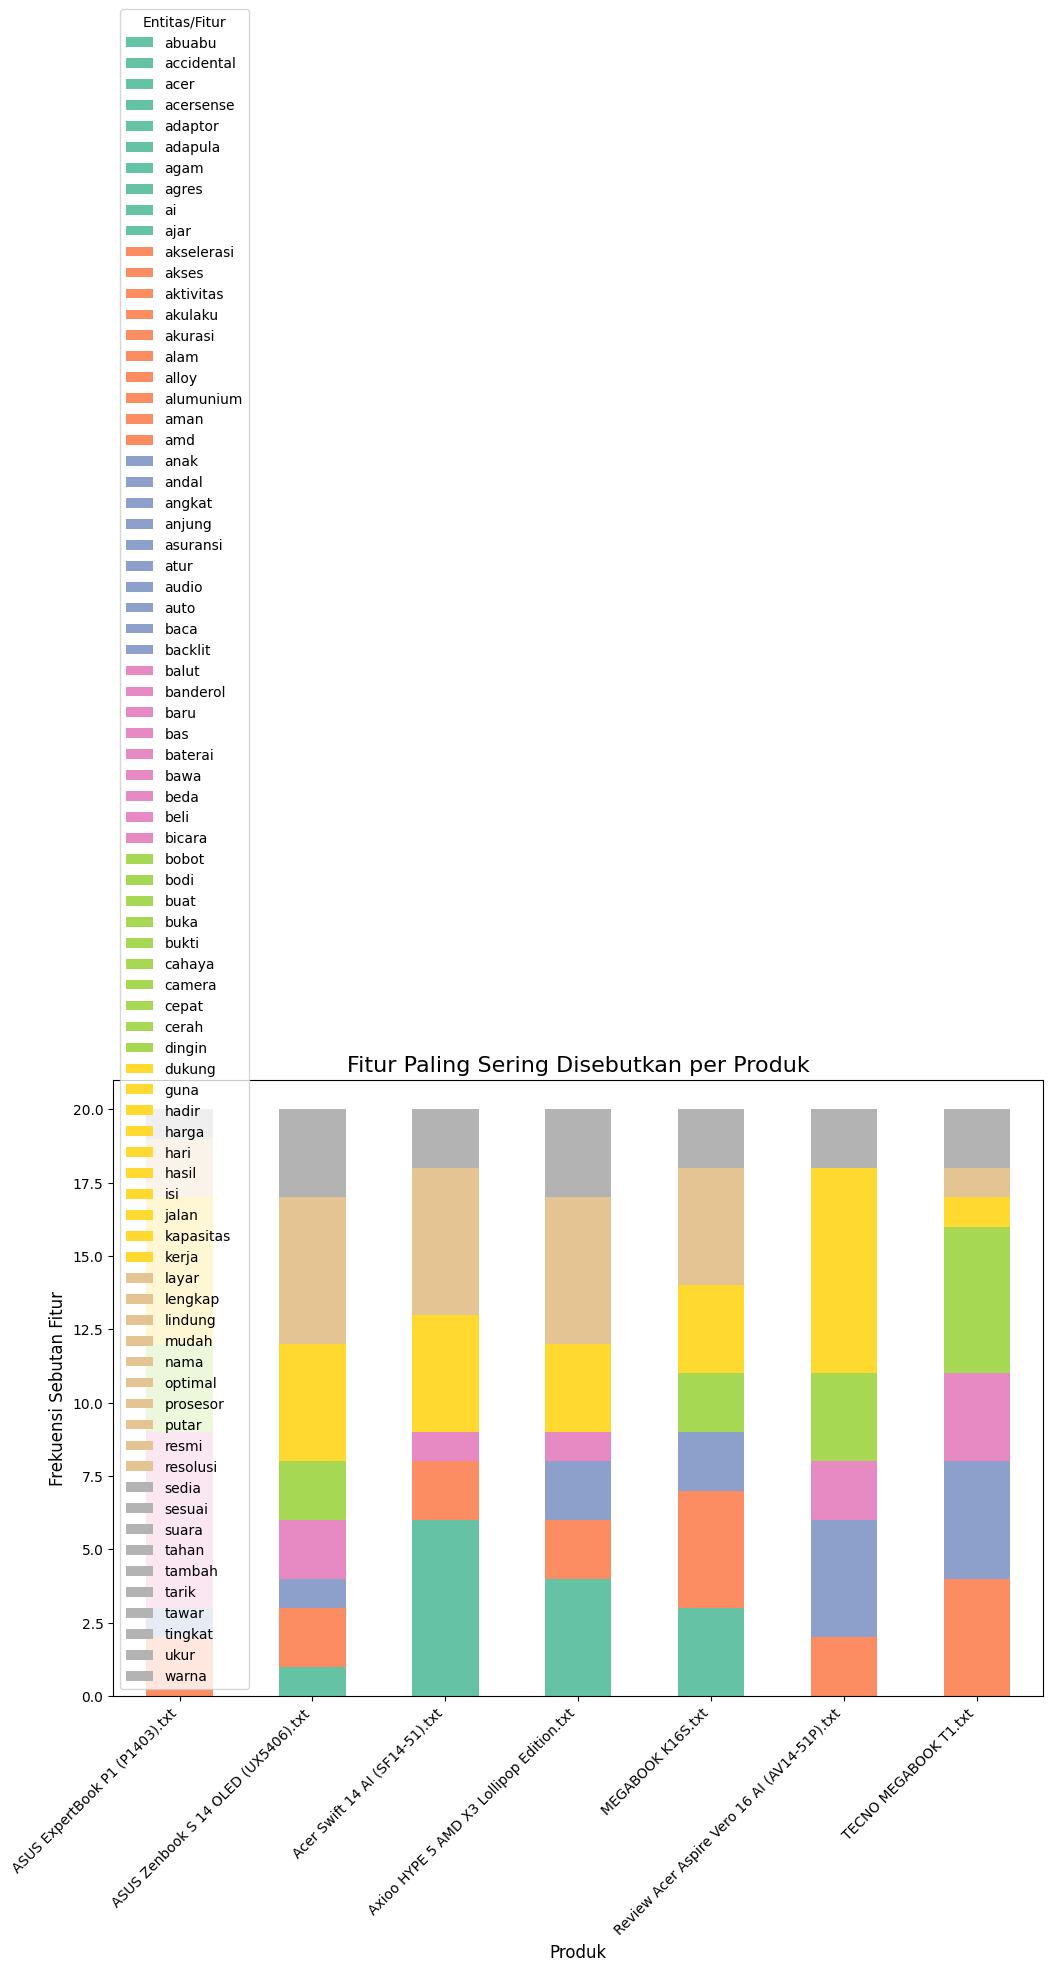

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misalkan 'feature_with_sentiment_df' adalah DataFrame yang sudah ada
# Jika Anda belum memiliki data tersebut, Anda bisa menjalankan analisis sentimen dan TF-IDF terlebih dahulu

# Visualisasi Sentimen per Produk
# Menghitung jumlah sentimen per produk
sentiment_counts = feature_with_sentiment_df.groupby(['File', 'Sentimen']).size().unstack(fill_value=0)

# Plot sentimen per produk
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))

# Menambahkan label dan judul
plt.title('Sentimen per Produk', fontsize=16)
plt.xlabel('Produk', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentimen', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Visualisasi Fitur Paling Sering Disebutkan per Produk
# Menampilkan 20 fitur TF-IDF teratas per produk
top_features = feature_with_sentiment_df.groupby(['File', 'Entitas/Fitur']).size().unstack(fill_value=0)

# Plot fitur yang paling sering disebutkan
plt.figure(figsize=(12, 8))
top_features.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='Set2')

# Menambahkan label dan judul
plt.title('Fitur Paling Sering Disebutkan per Produk', fontsize=16)
plt.xlabel('Produk', fontsize=12)
plt.ylabel('Frekuensi Sebutan Fitur', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
